In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
data = pd.read_csv('/content/GlobalLandTemperaturesByCountry.csv')
data

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
456950,1907-05-01,29.605,0.834,Saudi Arabia
456951,1907-06-01,32.434,0.805,Saudi Arabia
456952,1907-07-01,33.956,0.654,Saudi Arabia
456953,1907-08-01,33.135,0.894,Saudi Arabia


In [5]:
data = data.loc[data['Country'].isin(['Indonesia'])]
data

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
246308,1825-01-01,25.915,1.825,Indonesia
246309,1825-02-01,25.385,0.973,Indonesia
246310,1825-03-01,25.687,1.656,Indonesia
246311,1825-04-01,26.302,1.897,Indonesia
246312,1825-05-01,25.705,0.902,Indonesia
...,...,...,...,...
248568,2013-05-01,26.818,0.154,Indonesia
248569,2013-06-01,26.881,0.248,Indonesia
248570,2013-07-01,25.902,0.164,Indonesia
248571,2013-08-01,25.961,0.319,Indonesia


In [6]:
data.isnull().sum()

dt                                 0
AverageTemperature               386
AverageTemperatureUncertainty    386
Country                            0
dtype: int64

In [7]:
data.dropna(subset=['AverageTemperature'],inplace=True)
data.dropna(subset=['AverageTemperatureUncertainty'],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [8]:
data.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

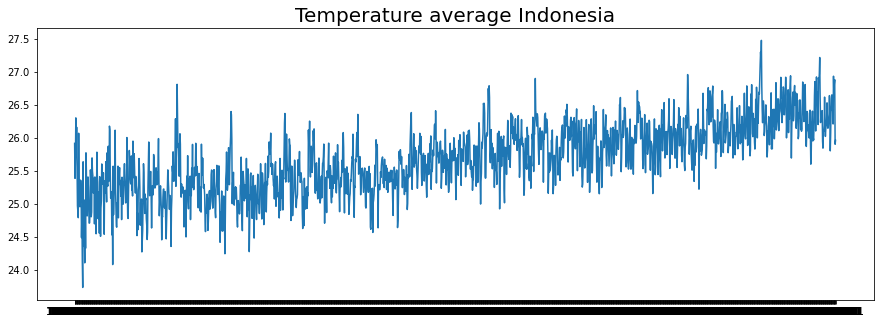

In [9]:
dates = data['dt'].values
temp  = data['AverageTemperature'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average Indonesia',
          fontsize=20);

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(temp, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_val, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [13]:
# menghitung minimum MAE
threshold = (temp.max() - temp.min()) * 10/100
threshold

0.37480000000000013

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [15]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=100,validation_data = val_set,callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


15/15 [==============================] - 7s 173ms/step - loss: 25.2887 - mae: 25.7887 - val_loss: 25.9365 - val_mae: 26.4365
Epoch 2/100
15/15 [==============================] - 2s 108ms/step - loss: 25.1312 - mae: 25.6312 - val_loss: 25.8081 - val_mae: 26.3081
Epoch 3/100
15/15 [==============================] - 2s 106ms/step - loss: 25.0145 - mae: 25.5145 - val_loss: 25.6993 - val_mae: 26.1993
Epoch 4/100
15/15 [==============================] - 2s 105ms/step - loss: 24.9060 - mae: 25.4060 - val_loss: 25.5915 - val_mae: 26.0915
Epoch 5/100
15/15 [==============================] - 2s 104ms/step - loss: 24.7993 - mae: 25.2993 - val_loss: 25.4859 - val_mae: 25.9859
Epoch 6/100
15/15 [==============================] - 2s 104ms/step - loss: 24.6959 - mae: 25.1959 - val_loss: 25.3849 - val_mae: 25.8849
Epoch 7/100
15/15 [==============================] - 2s 107ms/step - loss: 24.5942 - mae: 25.0942 - val_loss: 25.2819 - val_mae: 25.7819
Epoch 8/100
15/15 [==============================] - 

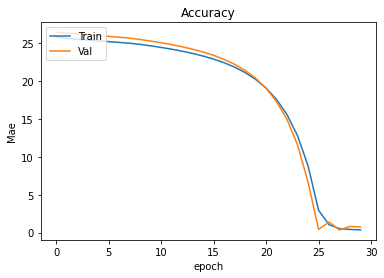

In [16]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Accuracy')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

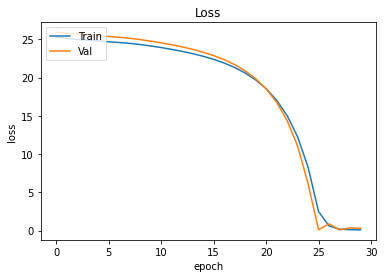

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()